In [26]:
import pandas as pd
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
import time
import warnings
import pickle
warnings.filterwarnings('ignore')

## `Needed Functions`

In [27]:
def calculate_pairwise_differences_any(data):
    ln = len(data.columns)
    for i in range(ln):
        for j in range(ln):
            if i < j:
                diff_name = f"{data.columns[i]}{data.columns[j]}"
                data[diff_name] = data[data.columns[i]] - data[data.columns[j]]
    return data


def classify_jk_r(df):
    """
    Classifies sources into:
    - 1 = Star
    - 2 = Galaxy
    - 0 = Ambiguous
    """
    classification = np.ones(len(df), dtype=int)*(-1)  # Default: ambiguous
    
    # Star conditions (below line1 or line3)
    is_star = (
        (df['rmag'] < 19.5) & (df['JmagKmag'] < 0.025) |  # Below horizontal line
         # Below rising line
        (df['rmag'] >= 19.5) & (df['JmagKmag'] < 0.025 - 0.1*(df['rmag'] - 19.5)**2)    # Below parabolic line
    )
    
    # Galaxy conditions (above line2)
    is_galaxy = ((df['rmag'] >= 19.5) & (df['JmagKmag'] > 0.025 + 0.025*(df['rmag'] - 19.5)) |
                  (df['rmag'] < 19.5) & (df['JmagKmag'] > 0.025))
    
    classification[is_star] = 0    # Stars
    classification[is_galaxy] = 1  # Galaxies
    
    return classification

## `Data`

In [28]:
filename = 'FP18_data.fit'
df = Table.read(filename).to_pandas()
df = df.iloc[:,:-4]

df = pd.concat([df.iloc[:,:5], calculate_pairwise_differences_any(df.iloc[:,5:])], axis=1)

st = StandardScaler()
result1 = st.fit_transform(df.iloc[:,25:])
standard_df = pd.DataFrame(result1, columns=df.iloc[:,25:].columns)

## `Color-Cut Method`

In [29]:
color_label = classify_jk_r(df)

color_df= pd.DataFrame()

color_df['color'] = color_label
color_df['True190'] = df['Hclass']

In [30]:
print(classification_report(color_df['True190'] , color_df['color'], digits=4, 
                            target_names=['Ambiguous', 'Star', 'Galaxy', 'Quasar']))

              precision    recall  f1-score   support

   Ambiguous     0.0000    0.0000    0.0000         0
        Star     0.7117    0.9281    0.8056      7731
      Galaxy     0.9023    0.9356    0.9186     36763
      Quasar     0.0000    0.0000    0.0000      4192

    accuracy                         0.8539     48686
   macro avg     0.4035    0.4659    0.4311     48686
weighted avg     0.7943    0.8539    0.8216     48686



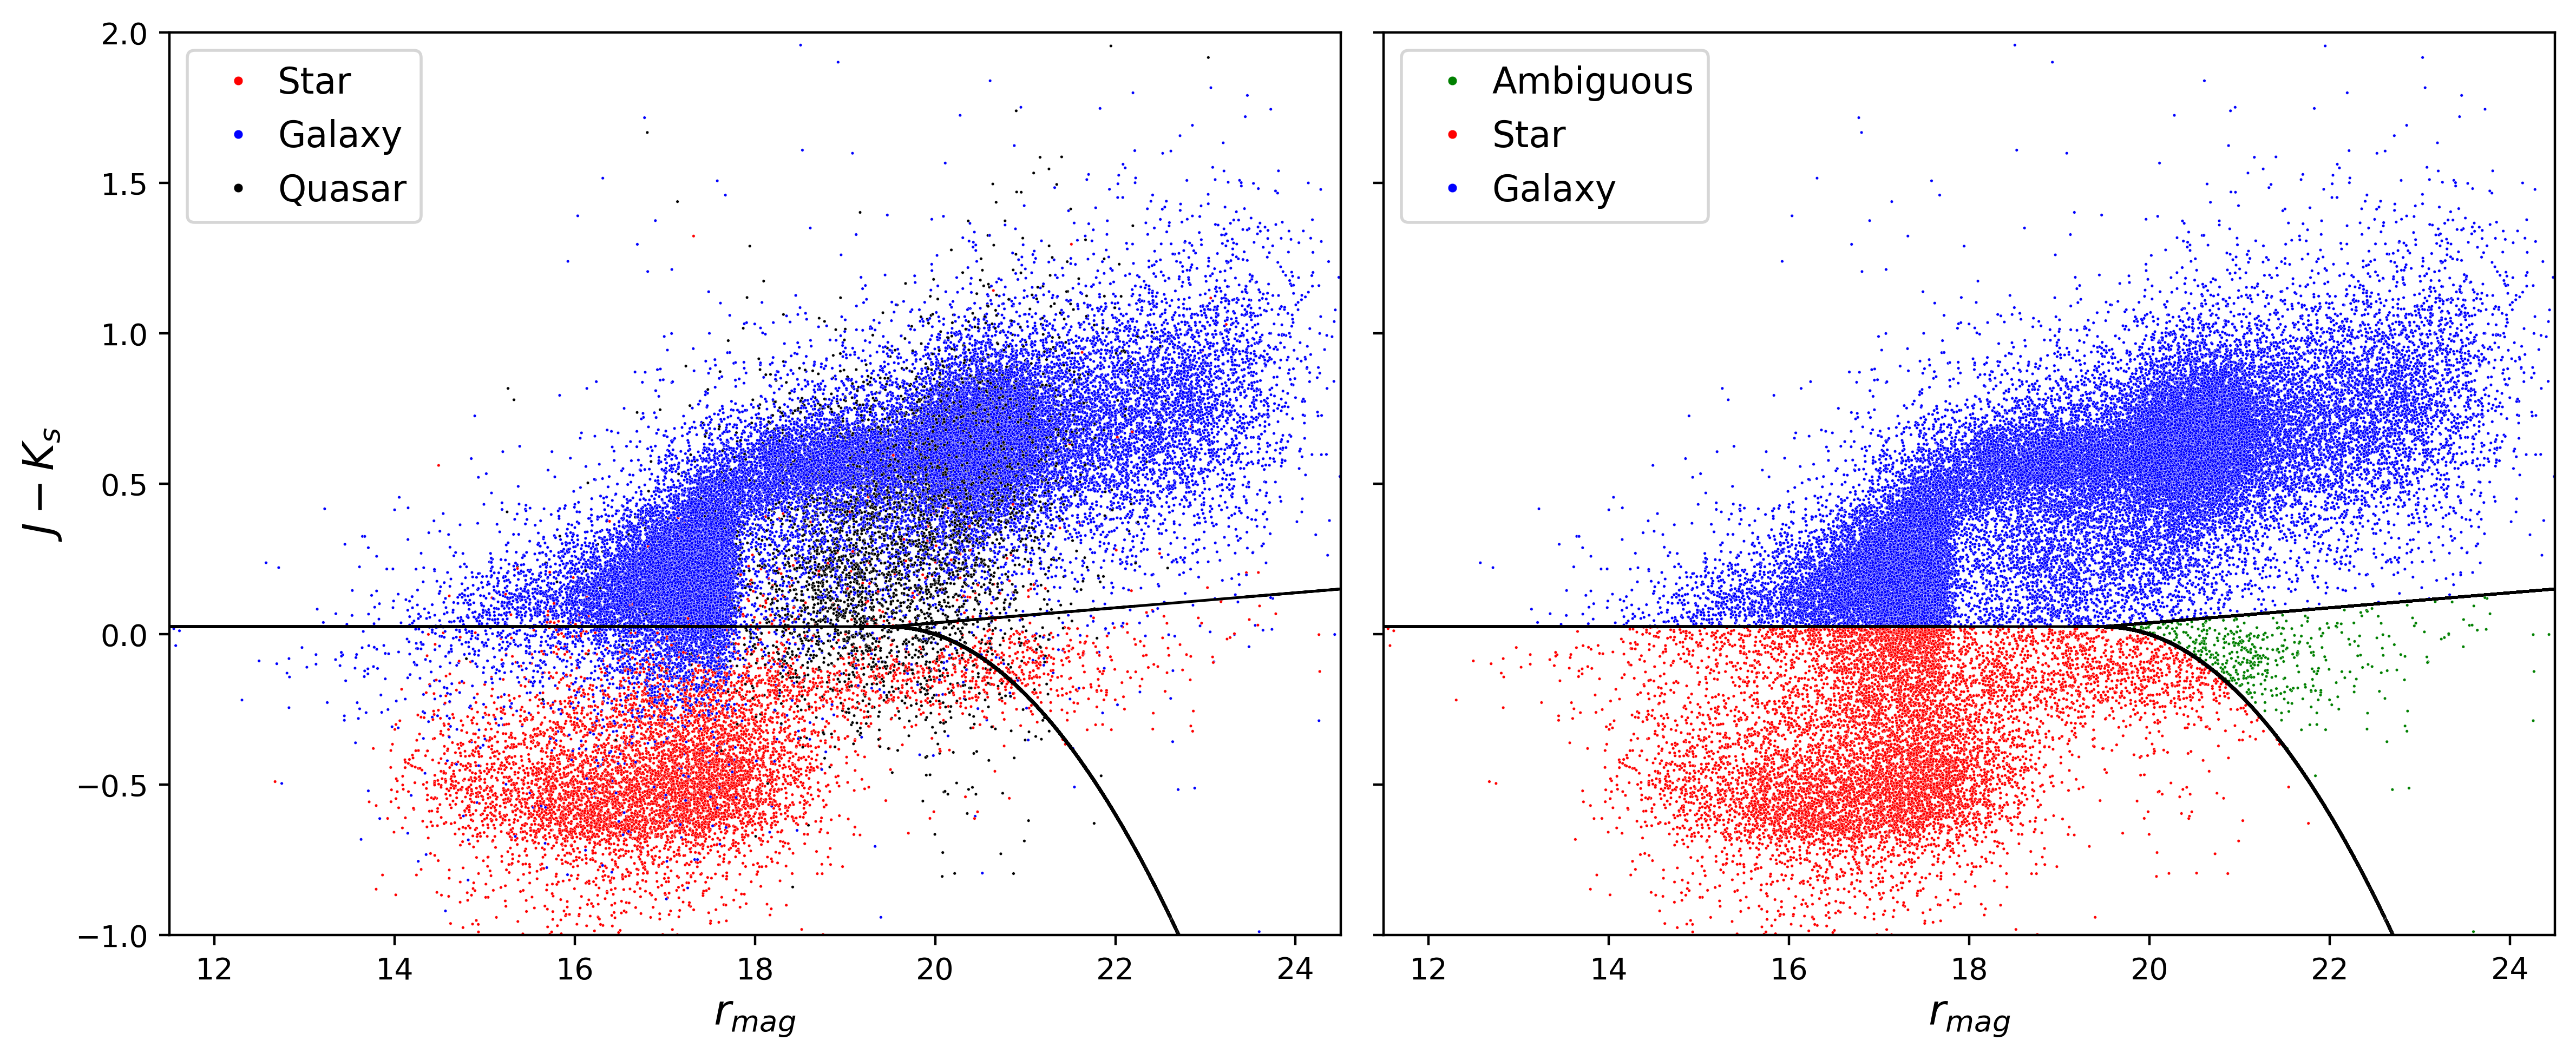

In [31]:
# Needed criteria for color-magnitude method
rmag_l19 = df['rmag'][df['rmag']<19.5]
rmag_h19 = df['rmag'][df['rmag']>19.5]

line1 = np.ones(len(rmag_l19))*0.025
line2 = 0.025 + 0.025 * (rmag_h19 - 19.5)
line3 = 0.025 - 0.1 * (rmag_h19 - 19.5)**2

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=400, sharex=True, sharey=True)

# --- Left Plot: Original Hclass ---
sc1 = sns.scatterplot(
    x=df['rmag'], 
    y=df['JmagKmag'], 
    s=1, 
    hue=df['Hclass'], 
    palette=['red', 'blue', 'k'],  # Quasar is black ('k')
    ax=ax1
)
ax1.plot(rmag_l19, line1, c='k', lw=0.9, label='_nolegend_')
ax1.plot(rmag_h19, line2, c='k', lw=0.9, label='_nolegend_')
ax1.scatter(rmag_h19, line3, c='k', s=0.01, alpha=0.4, label='_nolegend_')

# Get the handles and labels from the scatterplot
handles, labels = sc1.get_legend_handles_labels()

# Create custom legend with the correct colors and larger markers
legend1 = ax1.legend(
    handles=handles,
    labels=['Star', 'Galaxy', 'Quasar'],
    markerscale=3,  # Makes legend markers 3x larger
    handletextpad=0.1,
    fontsize=12
)

ax1.set_xlabel('$r_{mag}$', fontsize=14)
ax1.set_ylabel('$J - K_{s}$', fontsize=14)
ax1.set_ylim(-1, 2)
ax1.set_xlim(11.5, 24.5)

# --- Right Plot: New Classification ---
sc2 = sns.scatterplot(
    x=df['rmag'], 
    y=df['JmagKmag'], 
    s=1, 
    hue=color_label,
    palette=['green', 'red', 'blue'],
    ax=ax2
)
ax2.plot(rmag_l19, line1, c='k', lw=0.9, label='_nolegend_')
ax2.plot(rmag_h19, line2, c='k', lw=0.9, label='_nolegend_')
ax2.scatter(rmag_h19, line3, c='k', s=0.01, alpha=0.4, label='_nolegend_')

# Get the handles and labels from the scatterplot
handles, labels = sc2.get_legend_handles_labels()

# Customize legend with larger markers
legend2 = ax2.legend(
    handles=handles,
    labels=['Ambiguous', 'Star', 'Galaxy'],
    markerscale=3,  # Makes legend markers 3x larger
    handletextpad=0.1,
    fontsize=12
)
ax2.set_xlabel('$r_{mag}$', fontsize=14)
ax2.set_ylabel('')

plt.tight_layout()
plt.show()